# Requirements Installs

In [20]:
!pip install transformers torchvision pandas openpyxl pillow accelerate jiwer rouge-score

  Preparing metadata (setup.py) ... done
  Created wheel for rouge-score: filename=rouge_score-0.1.2-py3-none-any.whl size=24935 sha256=c9deafdf98d780345060556b1abafccaf845e63322ad8cbb0cdbfe22610f535b
  Stored in directory: /root/.cache/pip/wheels/5f/dd/89/461065a73be61a532ff8599a28e9beef17985c9e9c31e541b4
Successfully built rouge-score


# Libraries

In [22]:
import pandas as pd
import numpy as np
import torch
import gc
from torch.utils.data import Dataset
from PIL import Image, ImageEnhance, ImageOps
from transformers import (
    TrOCRProcessor,
    VisionEncoderDecoderModel,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)
import os
from jiwer import wer, cer
import matplotlib.pyplot as plt
from transformers.trainer_callback import TrainerCallback
from rouge_score import rouge_scorer
import warnings
warnings.filterwarnings("ignore", message=".*Trainer.tokenizer is now deprecated.*")

# Load Data

In [3]:
# Load your Excel file
df = pd.read_excel("/kaggle/input/data-fine-tune/TROCR-Labels.xlsx")  # Change to your file path
print(f"Loaded {len(df)} samples")
df.head()

Loaded 1870 samples


,image,word
0,prescription_opth_230_crop_0.jpg,Morning
1,prescription_opth_230_crop_1.jpg,test
2,prescription_opth_230_crop_2.jpg,Corneal
3,prescription_opth_230_crop_3.jpg,لاتانوبروست
4,prescription_opth_230_crop_4.jpg,Required


In [4]:
IMAGE_FOLDER = "/kaggle/input/cropped-images/TROCRImagesData"

# Image processing function

In [5]:
def preprocess_image(image):
    # Convert to grayscale
    image = image.convert('L')  # 'L' mode for grayscale
    # Enhance contrast
    enhancer = ImageEnhance.Contrast(image)
    image = enhancer.enhance(2.0)  # Increase contrast by factor of 2
    # Resize to a fixed height (e.g., 64px) while maintaining aspect ratio
    fixed_height = 64
    width_percent = (fixed_height / float(image.size[1]))
    new_width = int((float(image.size[0]) * float(width_percent)))
    image = image.resize((new_width, fixed_height), Image.Resampling.LANCZOS)
    # Convert back to RGB (required for TrOCR processor)
    image = image.convert('RGB')
    return image
    #########################################################################
    # gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # img_blur = cv2.GaussianBlur(gray, (5, 5), 0)
    # img_thresh = cv2.adaptiveThreshold(img_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, 20)
    # kernel = np.ones((2, 2), np.uint8)
    # img_morph = cv2.morphologyEx(img_thresh, cv2.MORPH_CLOSE, kernel, iterations=1)
    # clahe = cv2.createCLAHE(clipLimit=5.0, tileGridSize=(8, 8))
    # img_clahe = clahe.apply(img_morph)
    # return img_clahe

# Prepare Data

In [6]:
# Create PyTorch Dataset
class PrescriptionDataset(Dataset):
    def __init__(self, df, processor, image_folder):
        self.df = df
        self.processor = processor
        self.image_folder = image_folder

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get image name and label
        img_name = self.df.iloc[idx]['image']
        text_label = str(self.df.iloc[idx]['word'])
        
        # Load image
        image_path = os.path.join(self.image_folder, img_name)
        image = Image.open(image_path).convert('RGB')
        image = preprocess_image(image)  # Apply preprocessing

        # Process image and text
        pixel_values = self.processor(image, return_tensors="pt").pixel_values.squeeze()
        labels = self.processor.tokenizer(
            text_label,
            return_tensors="pt",
            padding="max_length",
            max_length=64,
            truncation=True
        ).input_ids.squeeze()

        return {
            "pixel_values": pixel_values,
            "labels": labels
        }

# Initialize model

In [7]:
MODEL_NAME = "microsoft/trocr-base-handwritten"
TEST_SIZE = 0.2

# Initialize processor
processor = TrOCRProcessor.from_pretrained(MODEL_NAME)

preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [8]:
model = VisionEncoderDecoderModel.from_pretrained(MODEL_NAME)
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id

config.json:   0%|          | 0.00/4.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.47.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## prepare data

In [9]:
# Split data
train_df = df.sample(frac=1-TEST_SIZE, random_state=42)
test_df = df.drop(train_df.index)

# Create datasets
train_dataset = PrescriptionDataset(train_df, processor, IMAGE_FOLDER)
eval_dataset = PrescriptionDataset(test_df, processor, IMAGE_FOLDER)

print(f"Train samples: {len(train_dataset)}, Eval samples: {len(eval_dataset)}")

Train samples: 1496, Eval samples: 374


# Model Training

## cleanup function

In [10]:
def cleanup():
    gc.collect()
    torch.cuda.empty_cache()
    !rm -rf /kaggle/working/*
cleanup()

## accuracy function

In [31]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
    # Safety checks
    vocab_size = len(processor.tokenizer)
    pred_ids = np.clip(pred_ids, 0, vocab_size - 1)
    # Decoding
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)
    cleanup()
    # Metric calculation
    return {
        "cer": cer(label_str, pred_str),
        "wer": wer(label_str, pred_str),
    }

## pre definition

In [27]:
BATCH_SIZE = 4 # less is better
EPOCHS = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

warnings.filterwarnings("ignore", 
    message=".*Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.*")

## Metrecies

In [28]:
class MetricsCallback(TrainerCallback):
    def __init__(self):
        self.training_logs = []
        self.eval_logs = []
        
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs:
            step_logs = {k: v for k, v in logs.items()}
            step_logs['step'] = state.global_step
            
            if 'loss' in logs and 'eval_loss' not in logs:
                self.training_logs.append(step_logs)
            elif 'eval_loss' in logs:
                self.eval_logs.append(step_logs)

metrics_callback = MetricsCallback()

## Training

In [32]:
training_args = Seq2SeqTrainingArguments(
    output_dir="./",  # Use root directory to minimize writes
    per_device_train_batch_size=BATCH_SIZE,  # Reduced from 8 to save memory
    per_device_eval_batch_size=BATCH_SIZE,
    gradient_accumulation_steps=2,  # Compensate for smaller batch size
    # Evaluation and logging
    evaluation_strategy="epoch",
    logging_strategy="steps",  # More frequent logging than epoch
    logging_steps=50,          # Log every 50 steps
    # Disable all saving to conserve space
    save_strategy="no",        # No checkpoint saving
    save_total_limit=0,        # Keep zero checkpoints
    load_best_model_at_end=False,
    # Training hyperparameters
    learning_rate=4e-5,
    num_train_epochs=EPOCHS,
    warmup_ratio=0.1,
    weight_decay=0.01,
    # Memory optimizations
    fp16=True,  # Enable mixed precision if GPU supports it
    fp16_full_eval=True,
    dataloader_pin_memory=False,  # Reduce memory pressure
    dataloader_num_workers=2,     # Optimal for Kaggle
    # Generation config
    predict_with_generate=True,
    generation_max_length=64,
    generation_num_beams=1,       # Faster than multi-beam
    # Disable unnecessary features
    report_to="none",             # No external logging
)

# Initialize trainer with fixed compute_metrics
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    tokenizer=processor,  # Explicitly pass the processor to avoid the warning
        # feature_extractor=processor.feature_extractor,  # Required for image models
    # tokenizer=processor.tokenizer,                 # Required for text generation
)

trainer.add_callback(metrics_callback)
# Run training
train_result = trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-32-18c705ec7328>:33: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss,Cer,Wer
1,0.020000,0.080018,0.244000,0.377500
2,0.052700,0.077172,0.242222,0.397500
3,0.037100,0.065944,0.231556,0.332500
4,0.026900,0.063722,0.233778,0.320000
5,0.013300,0.060333,0.180444,0.305000
6,0.010100,0.050753,0.144000,0.260000
7,0.005500,0.050021,0.117333,0.222500
8,0.003600,0.050393,0.113778,0.217500
9,0.001900,0.046690,0.111556,0.205000
10,0.000400,0.046335,0.108000,0.202500


Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.
Trainer.tokenizer is now deprecated. You should use Tr

## visualization for train

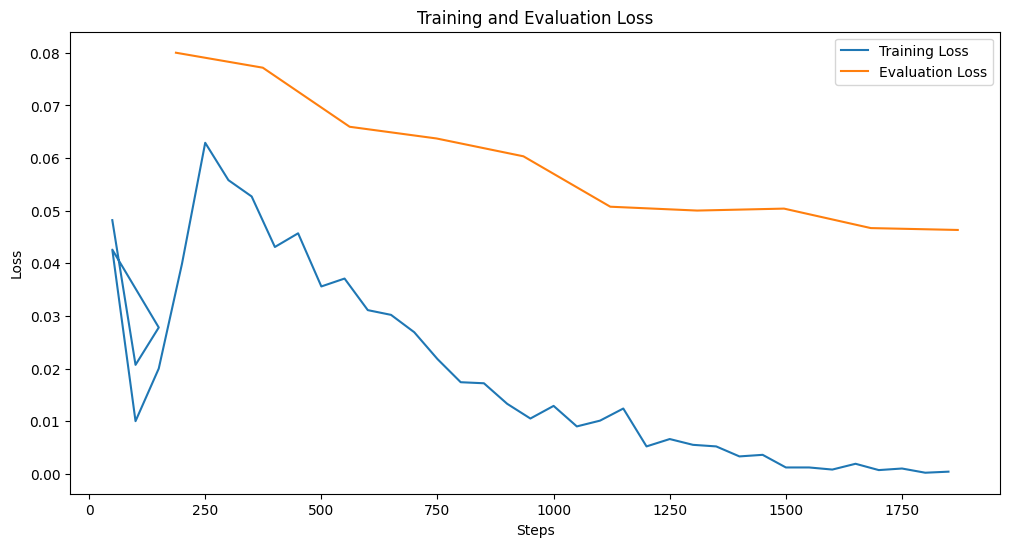

In [34]:
# Convert logs to DataFrame
train_df = pd.DataFrame(metrics_callback.training_logs)
eval_df = pd.DataFrame(metrics_callback.eval_logs)

# Plot loss curves
plt.figure(figsize=(12, 6))
plt.plot(train_df['step'], train_df['loss'], label='Training Loss')
plt.plot(eval_df['step'], eval_df['eval_loss'], label='Evaluation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Evaluation Loss')
plt.savefig('loss_curves.png')

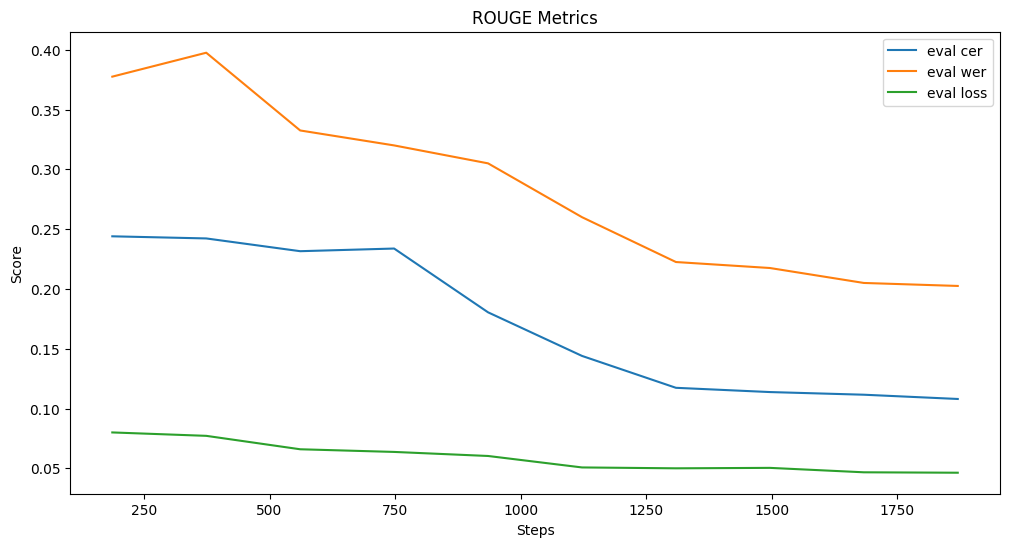

In [47]:
# Plot ROUGE metrics

plt.figure(figsize=(12, 6))
plt.plot(eval_df['step'], eval_df['eval_cer'], label='eval cer')
plt.plot(eval_df['step'], eval_df['eval_wer'], label='eval wer')
plt.plot(eval_df['step'], eval_df['eval_loss'], label='eval loss')
plt.xlabel('Steps')
plt.ylabel('Score')
plt.legend()
plt.title('ROUGE Metrics')
plt.savefig('rouge_metrics.png')

## save the whole model

In [14]:
trainer.save_model("final_model")
!tar -czvf model.tar.gz final_model  # Compress
!rm -rf final_model  # Remove uncompressed version

final_model/
final_model/special_tokens_map.json
final_model/tokenizer_config.json
final_model/merges.txt
final_model/generation_config.json
final_model/tokenizer.json
final_model/config.json
final_model/preprocessor_config.json
final_model/model.safetensors
final_model/training_args.bin
final_model/vocab.json


## save model weights

In [15]:
# Save model weights only
torch.save(model.state_dict(), "model_weights.pth")
print("Model weights saved as 'model_weights.pth'")

Model weights saved as 'model_weights.pth'


# Test

## load the whole model

In [16]:
# Load the entire model (architecture + weights)
# loaded_model = VisionEncoderDecoderModel.from_pretrained("final_model")
# loaded_model.to(device)  # Move to GPU if available
# print("Entire model loaded successfully.")

## load model with weights

In [35]:
# Load model weights only into a new model
model = VisionEncoderDecoderModel.from_pretrained(MODEL_NAME)
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.load_state_dict(torch.load("/kaggle/working/model_weights.pth"))
model.to(device)  # Move to GPU if available
print("Model weights loaded successfully into a new model.")

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "qkv_bias": false,
  "transformers_version": "4.47.0"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "gelu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_model": 1024,
  "decoder_attention_heads": 16,
  "decoder_ffn_dim": 4096,
  "decoder

Model weights loaded successfully into a new model.


## test accuracy

In [36]:
# Initialize counters
total_samples = len(test_df)
correct_exact = 0  # Exact match (whole word)
correct_chars = 0   # Character-level accuracy
total_chars = 0

# Test loop
for i in range(total_samples):
    # Load and preprocess image (same as during training)
    test_image_path = os.path.join(IMAGE_FOLDER, test_df.iloc[i]['image'])
    test_image = Image.open(test_image_path).convert('RGB')
    test_image = preprocess_image(test_image)  # Apply preprocessing
    
    # Generate prediction
    with torch.no_grad():
        pixel_values = processor(test_image, return_tensors="pt").pixel_values.to(device)
        generated_ids = model.generate(pixel_values)
        predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    
    # Get ground truth
    true_text = str(test_df.iloc[i]['word'])
    
    # Calculate exact match
    if predicted_text.strip() == true_text.strip():
        correct_exact += 1
    
    # Calculate character-level accuracy
    min_len = min(len(predicted_text), len(true_text))
    matched_chars = sum(1 for a, b in zip(predicted_text, true_text) if a == b)
    correct_chars += matched_chars
    total_chars += max(len(predicted_text), len(true_text))

# Compute metrics
exact_accuracy = (correct_exact / total_samples) * 100
char_accuracy = (correct_chars / total_chars) * 100

# Print summary
print("\n=== Test Results ===")
print(f"Exact Match Accuracy: {exact_accuracy:.2f}% ({correct_exact}/{total_samples})")
print(f"Character-Level Accuracy: {char_accuracy:.2f}%")

# print("\nSample Predictions (First 5):")
# for i in range(min(5, total_samples)):
#     test_image_path = os.path.join(IMAGE_FOLDER, test_df.iloc[i]['image'])
#     true_text = str(test_df.iloc[i]['word'])
#     with torch.no_grad():
#         pixel_values = processor(Image.open(test_image_path).convert('RGB'), return_tensors="pt").pixel_values.to(device)
#         predicted_text = processor.batch_decode(model.generate(pixel_values), skip_special_tokens=True)[0]
#     print(f"Image: {test_df.iloc[i]['image']}")
#     print(f"Predicted: '{predicted_text}' | Actual: '{true_text}'")
#     print("-----")


=== Test Results ===
Exact Match Accuracy: 79.95% (299/374)
Character-Level Accuracy: 83.34%


## test with one image

In [ ]:
def predict_and_display(image_path, model, processor, device="cuda"):
    # Load and preprocess the image
    image = Image.open(image_path).convert("RGB")
    processed_image = preprocess_image(image)  # Use the same preprocessing as training

    # Display the image
    plt.figure(figsize=(8, 4))
    plt.imshow(processed_image)
    plt.axis("off")
    plt.show()

    # Generate prediction
    pixel_values = processor(processed_image, return_tensors="pt").pixel_values.to(device)

    with torch.no_grad():
        generated_ids = model.generate(pixel_values)
        predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    print(f"Predicted Text: '{predicted_text}'")

In [ ]:
# Example usage (replace with your image path)
test_image_path = "/kaggle/input/TROCRImagesData/PrescriptionImagesData/Dental_prescription_482_crop_0.jpg"
predict_and_display(test_image_path, model, processor, device)

# END